In [197]:
%pylab inline
import pandas as pd
from sklearn.cluster import DBSCAN
from statsmodels.tsa.stattools import adfuller
from pandas.tools.plotting import autocorrelation_plot
rcParams['figure.figsize'] = 25, 10

Populating the interactive namespace from numpy and matplotlib


In [198]:
# Read raw dataset (very large)
# Don't care too much about warnings...
df = pd.read_csv('database.csv', quotechar='"')
pd.set_option('display.max_columns', 30)
pd.set_option('display.max_rows', 300)
pd.options.display.max_rows = 999

In [199]:
df['Victim Count'].value_counts()

0     586059
1      38750
2       8156
3       2847
4       1084
5        510
9        290
6        286
7        168
10       160
8        144
Name: Victim Count, dtype: int64

In [200]:
months =  ['January', 'February', 'March', 'April', 'May', 'June', 'July',
              'August', 'September', 'October', 'November', 'December']
months_mapping = dict(zip(months, range(1, len(months)+1)))
df['Month'] = df['Month'].map(months_mapping).astype(int)

In [201]:
from scipy.stats import kurtosis, skew
dummy =  [1,3,4,5,6,7,8,9,10,11,12]
dummy = np.asarray(dummy)
kurtosis(dummy[1:] - dummy[:-1])

5.111111111111105

In [202]:
# Select only "state" and "year" columns, counting rows (=homicidies) for each pair
df_year = df[['State','Year']].groupby(['State','Year']).size()
df_year_month=df[['State','Year', 'Month']].groupby(['State','Year', 'Month']).size()
df_month=df[['State', 'Month']].groupby(['State','Month']).size()

In [203]:
states = df['State'].drop_duplicates().tolist()

In [204]:
states[0] = 'Arkansas'
states[2] = 'Alaska'

In [205]:
# Transform in a set of time series
year_month_df = pd.DataFrame()
for sname in states:
    year_month_df[sname] = df_year_month[sname]

In [206]:
states[0] = 'Alaska'
states[2] = 'Arkansas'

In [220]:
# Some states dominate --> normalize, and also fill "empty" slots (NaN values, white spots)
init_year_month_df = pd.DataFrame()
for sname in states:
#     print my_df[my_df[sname][my_df[sname].isnull()]]
    init_year_month_df[sname] = (year_month_df[sname] - year_month_df[sname].mean() ) / year_month_df[sname].std()
    normalized_year_month_df[sname][normalized_year_month_df[sname].isnull()] = 0.0 # the NaN values are created as a result of the groupby operation                                             
    # given that for some states there are no recorded murders for specific years

In [209]:
norm_year_month_df = pd.DataFrame()
for sname in states:
    norm_year_month_df[sname] = ((year_month_df[sname] - year_month_df[sname].mean() ) / year_month_df[sname].std())
    norm_year_month_df[sname][norm_year_month_df[sname].isnull()] = 0.0
    
fin_year_month_df = pd.DataFrame()
for sname in states:
    fin_year_month_df[sname] = norm_year_month_df[sname].rolling(window=12).mean() - (norm_year_month_df[sname].rolling(window=12).mean()).ewm(halflife=12).mean()
#     norm_year_month_df[sname][norm_year_month_df[sname].isnull()] = 0.0
fin_year_month_df.dropna(inplace=True)

In [301]:
# Transform in a set of time series
year_df = pd.DataFrame()
for sname in states:
    year_df[sname] = df_year[sname]

In [302]:
# Some states dominate --> normalize, and also fill "empty" slots (NaN values, white spots)
normalized_year_df = pd.DataFrame()
for sname in states:
#     print my_df[my_df[sname][my_df[sname].isnull()]]
    normalized_year_df[sname] = (((year_df[sname] - year_df[sname].mean() ) / year_df[sname].std()).ewm(halflife=12).mean()) - (((year_df[sname] - year_df[sname].mean() ) / year_df[sname].std()).ewm(halflife=12).mean()).ewm(halflife=12).mean()
    normalized_year_df[sname][normalized_year_df[sname].isnull()] = 0.0 # the NaN values are created as a result of the groupby operation
                                              # given that for some states there are no recorded murders for specific years

In [304]:
# Transform in a set of time series
month_df = pd.DataFrame()
for sname in states:
    month_df[sname] = df_month[sname]

In [305]:
# Some states dominate --> normalize, and also fill "empty" slots (NaN values, white spots)
normalized_month_df = pd.DataFrame()
for sname in states:
#     print my_df[my_df[sname][my_df[sname].isnull()]]
    normalized_month_df[sname] = (((month_df[sname] - month_df[sname].mean() ) / month_df[sname].std()).ewm(halflife=12).mean()) - (((month_df[sname] - month_df[sname].mean() ) / month_df[sname].std()).ewm(halflife=12).mean()).ewm(halflife=12).mean()
    normalized_month_df[sname][normalized_month_df[sname].isnull()] = 0.0 # the NaN values are created as a result of the groupby operation
                                              # given that for some states there are no recorded murders for specific years

In [307]:
# If you need to use directly the dataset in clustering, you might want 
# to translate the DataFrame into an array: rows = states, columns = years:
matrix_series = normalized_month_df.T.as_matrix()

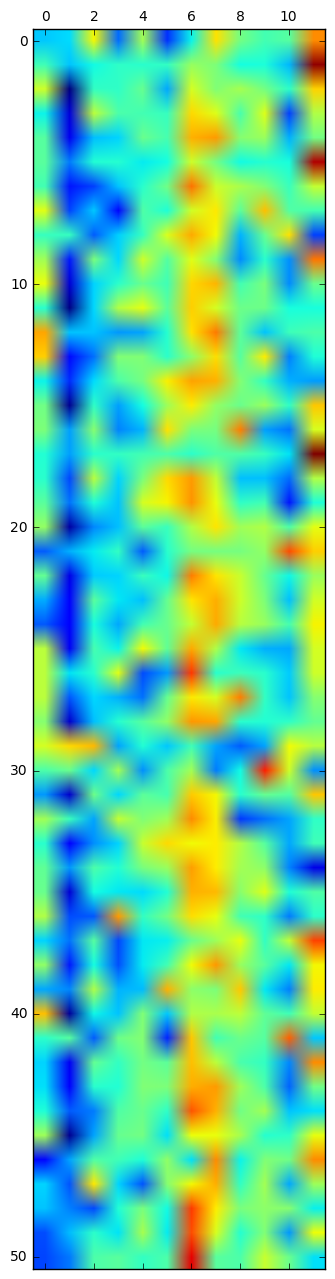

In [308]:
matshow(matrix_series, interpolation=None)
plt.xlabel('Months', fontsize=16)
plt.ylabel('States', fontsize=16)
tick_params(labelbottom='on', labeltop='off')
tick_params(axis='x', labelsize=16)
tick_params(axis='y', labelsize=16)

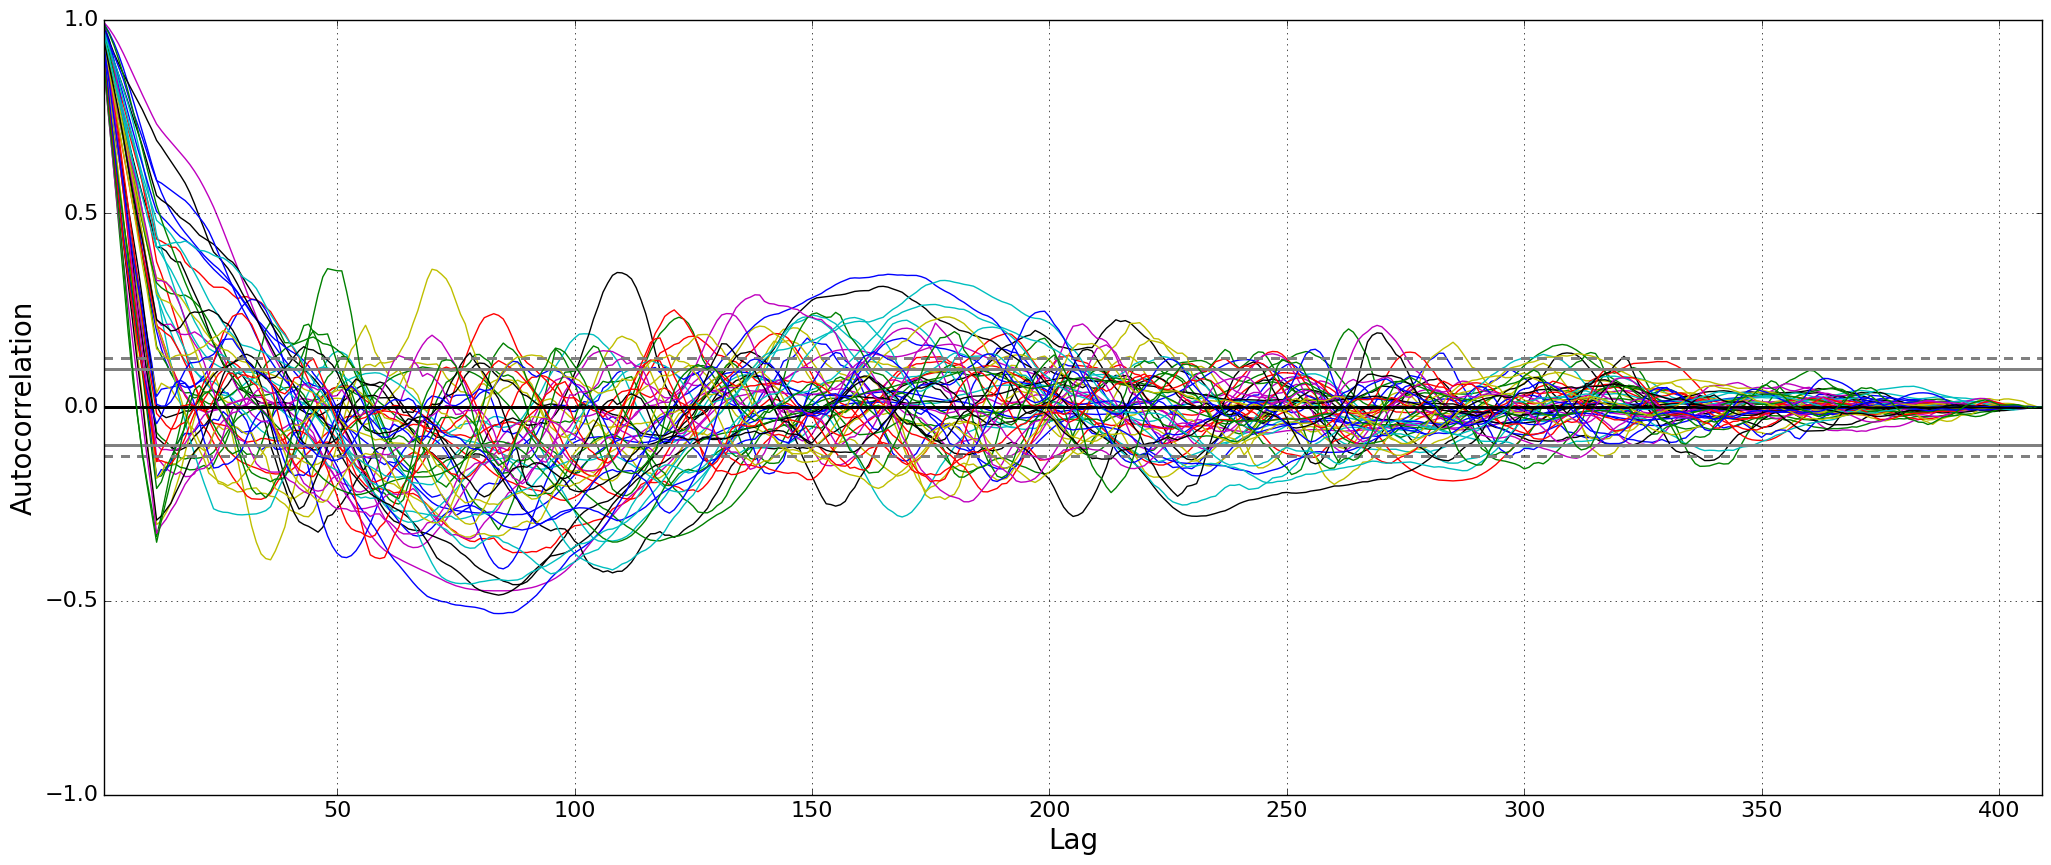

In [219]:
for sname in states:
    autocorrelation_plot(fin_year_month_df[sname])
tick_params(axis='x', labelsize=16)
tick_params(axis='y', labelsize=16)
plt.xlabel('Lag', fontsize=20)
plt.ylabel('Autocorrelation', fontsize=20)
# grid(color='k', linestyle='--', linewidth=0.5)

In [213]:
indices = []

years = np.arange(1980, 2015)
months = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
for year in years:
    for month in months:
        indices.append(str(year)+"-"+str(month))
indices = pd.to_datetime(indices, format='%Y-%m')
normalized_year_month_df.index = indices
year_month_df.index = indices
norm_year_month_df.index = indices
fin_year_month_df.index = indices
# normalized_year_month_df.index = normalized_year_month_df.index.strftime('%Y-%m')

In [106]:
year_abbreviations = ['\'80', '\'81', '\'82', '\'83', '\'84','\'85','\'86', '\'87','\'88','\'89',
       '\'90', '\'91', '\'92', '\'93', '\'94','\'95','\'96', '\'97','\'98','\'99',
       '\'00', '\'01', '\'02', '\'03', '\'04','\'05','\'06', '\'07','\'08','\'09',
       '\'10', '\'11', '\'12', '\'13', '\'14']

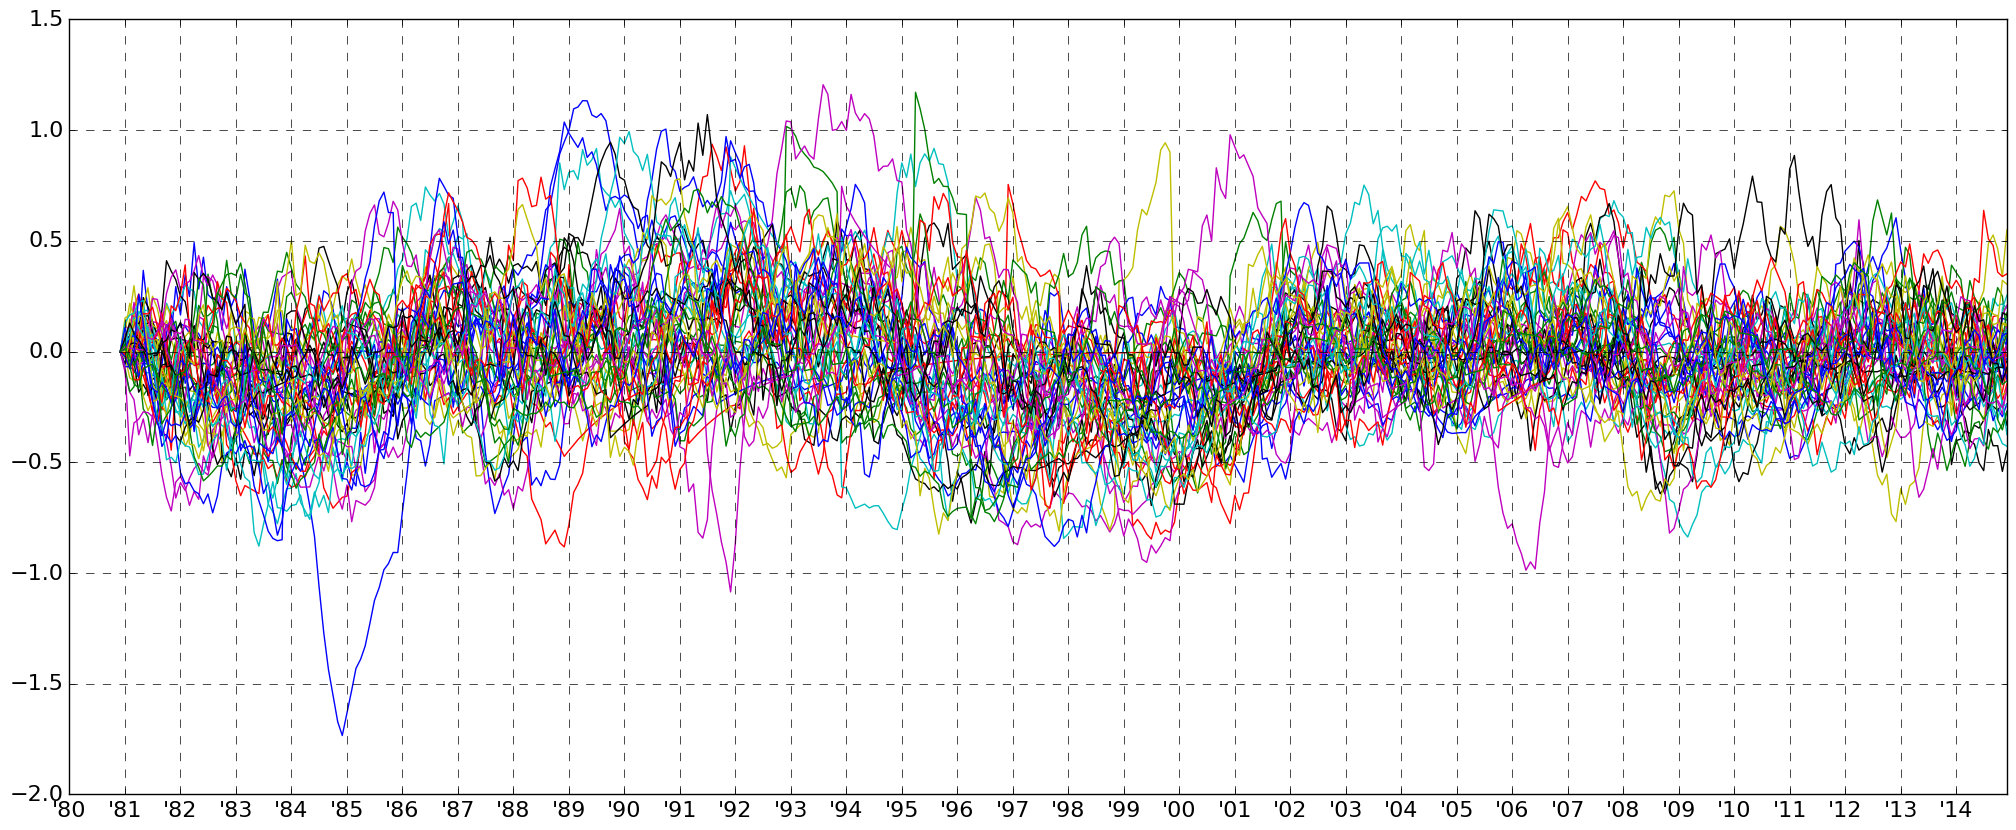

In [223]:
for sname in states:
    plot(fin_year_month_df[sname])
# plot(norm_year_month_df['Alaska'], 'r-')
xticks(normalized_year_month_df.index[0:len(normalized_year_month_df.index):12], year_abbreviations)
tick_params(axis='x', labelsize=16)
tick_params(axis='y', labelsize=16)
grid(color='k', linestyle='--', linewidth=0.5)

In [313]:
# for sname in states:
#     print sname
#     print adfuller(normalized_year_month_df[sname], autolag='AIC')
#     print adfuller(norm_year_month_df[sname],autolag='AIC')

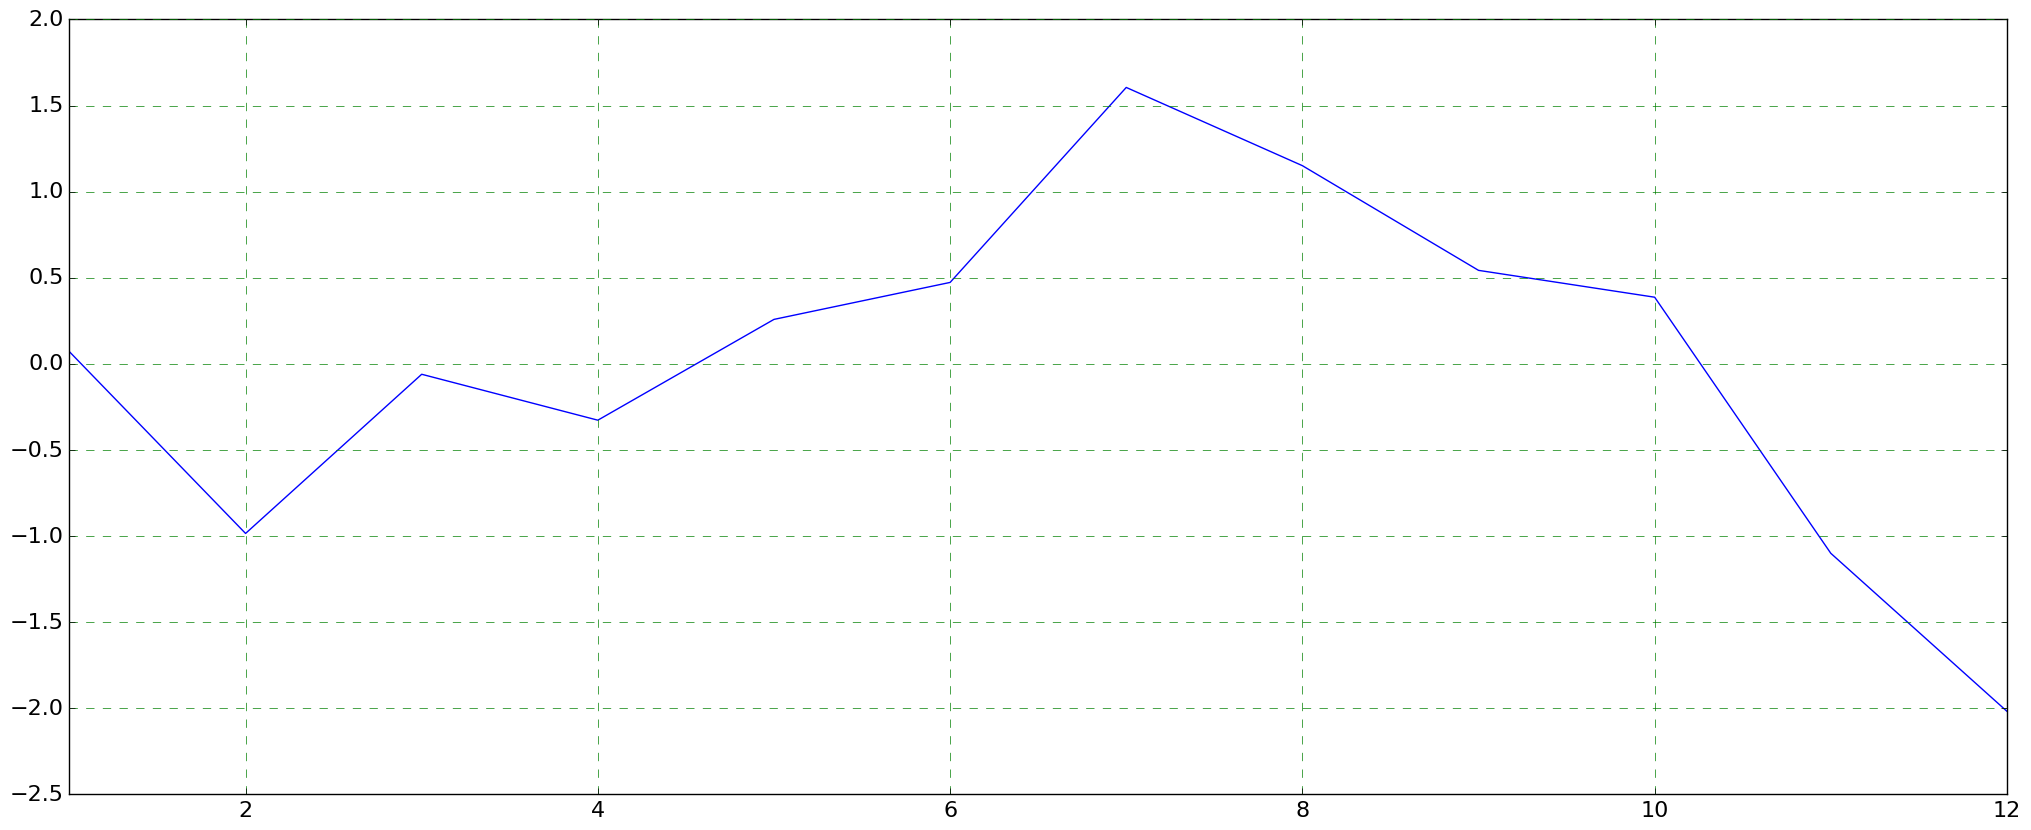

In [314]:
plot(normalized_month_df['New York'])
tick_params(axis='x', labelsize=16)
tick_params(axis='y', labelsize=16)
xlim( (1, 12) )
grid(color='g', linestyle='--', linewidth=0.5)

(1980, 2014)

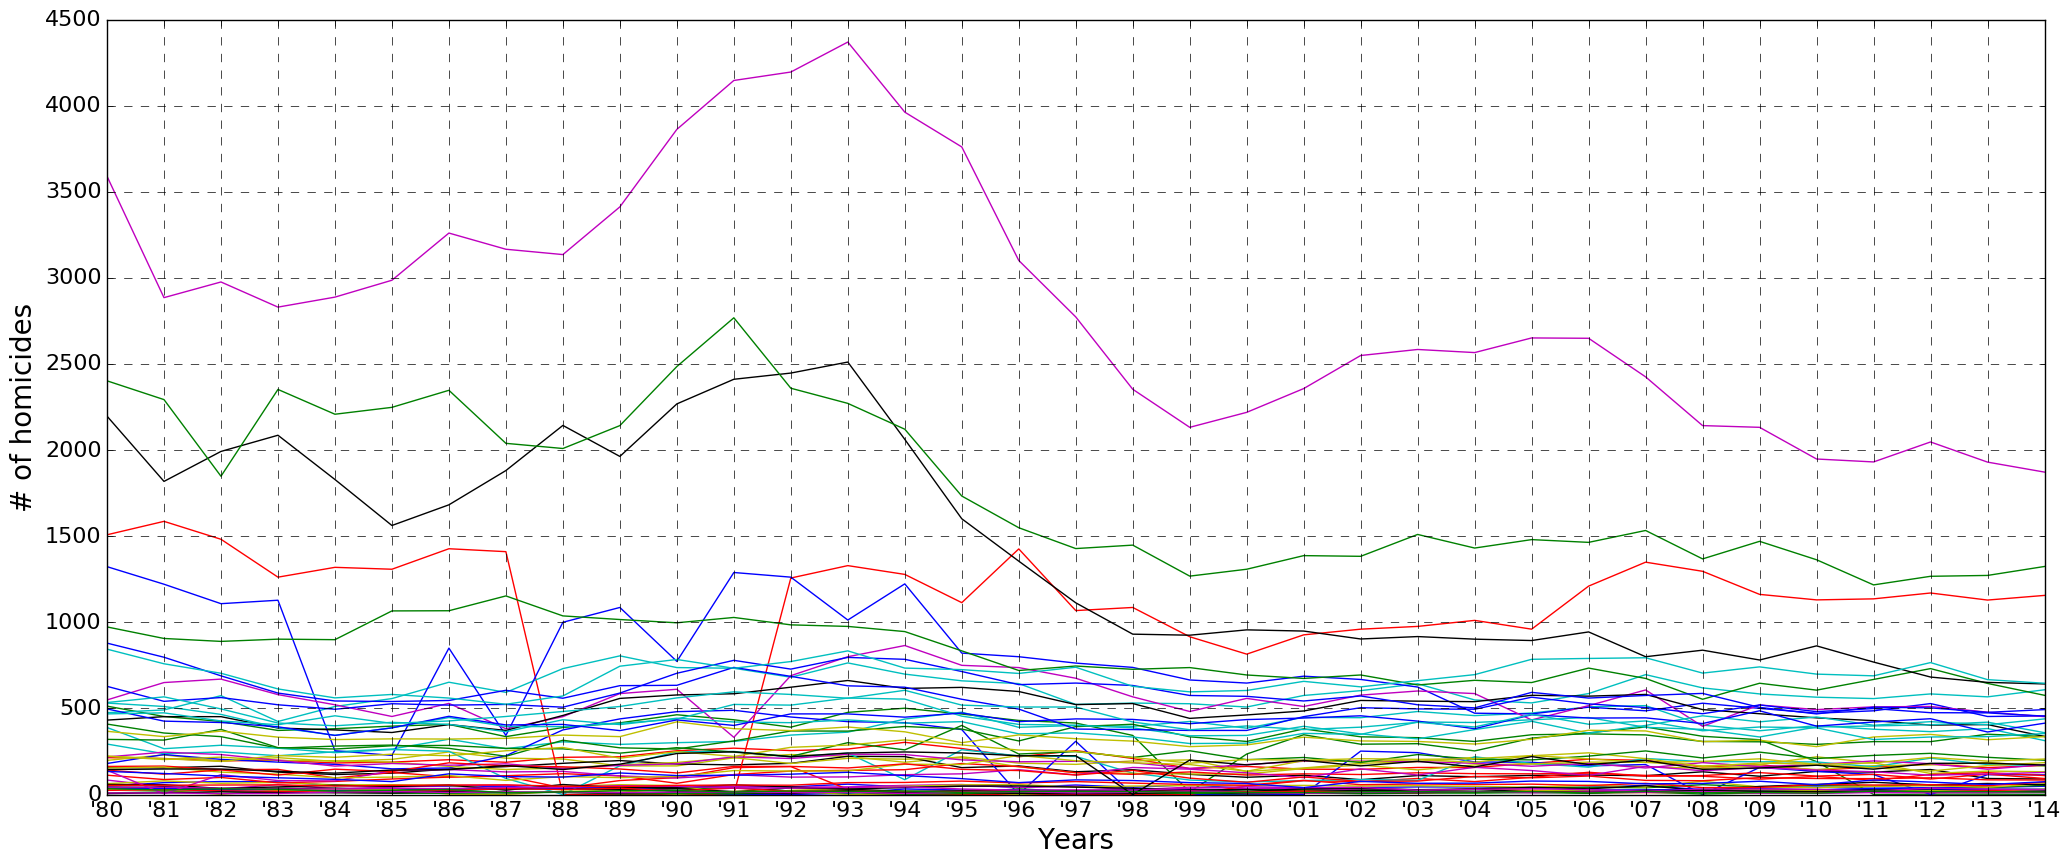

In [323]:
for sname in states:
    plot(year_df[sname])
xticks(normalized_year_df.index[0:len(normalized_year_df.index):1], year_abbreviations)
tick_params(axis='x', labelsize=16)
tick_params(axis='y', labelsize=16)
plt.xlabel('Years', fontsize=20)
plt.ylabel('# of homicides', fontsize=20)
grid(color='k', linestyle='--', linewidth=0.5)
xlim( (1980, 2014) )
# legend(loc='upper right', shadow=True) #California, Texas, New York

In [198]:
from dtw import dtw
def distance(x,y):
    return abs(x-y)

In [199]:
state_list = normalized_year_df.columns
dd1 = [ [ (dtw(norm_year_month_df[state_list[x]],norm_year_month_df[state_list[y]],distance)[0] if y > x else -1)  for y in range(len(state_list)) ] 
       for x in range(len(state_list)) ] #the for with x is the outer for
dd2 = [ [ (dd1[x][y] if y > x else dd1[y][x])  for y in range(len(state_list)) ] for x in range(len(state_list)) ]
for i in range(len(state_list)):
    dd2[i][i] = 0.0

In [200]:
# np.savetxt("dd2.csv", dd2, delimiter=",")
# dd2 = genfromtxt('dd2.csv', delimiter=',')

In [201]:
dd1_nohl = [ [ (dtw(normalized_year_month_df[state_list[x]],normalized_year_month_df[state_list[y]],distance)[0] if y > x else -1)  for y in range(len(state_list)) ] 
       for x in range(len(state_list)) ] #the for with x is the outer for
dd2_nohl = [ [ (dd1_nohl[x][y] if y > x else dd1_nohl[y][x])  for y in range(len(state_list)) ] for x in range(len(state_list)) ]
for i in range(len(state_list)):
    dd2_nohl[i][i] = 0.0

In [202]:
# np.savetxt("dd2_nohl.csv", dd2_nohl, delimiter=",")
# dd2_nohl = genfromtxt('dd2_nohl.csv', delimiter=',')

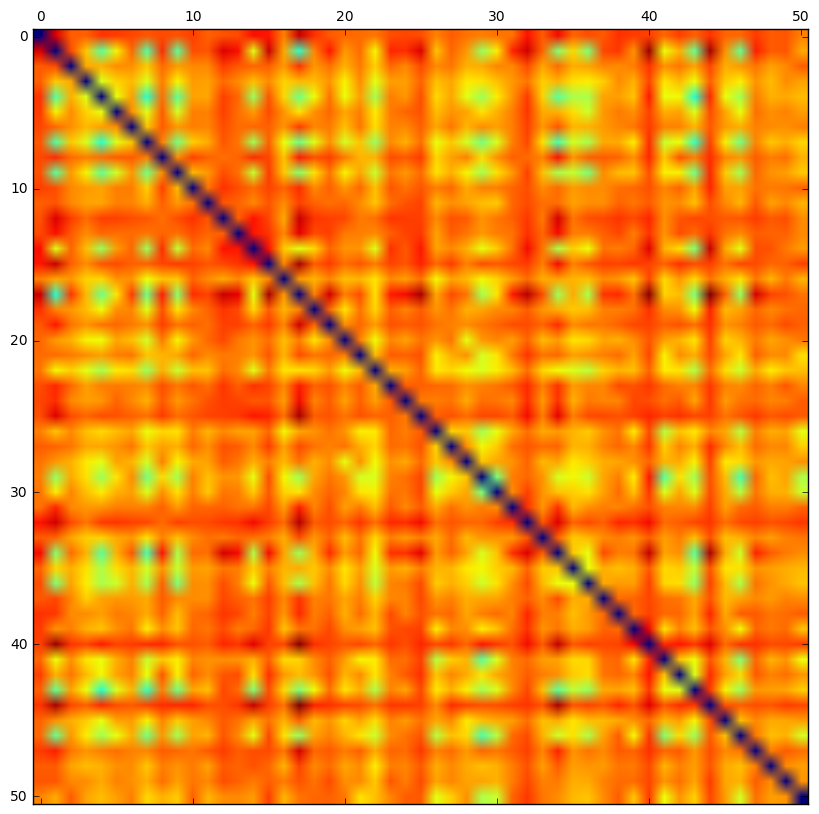

In [203]:
matshow(dd2, interpolation=None, aspect='auto')

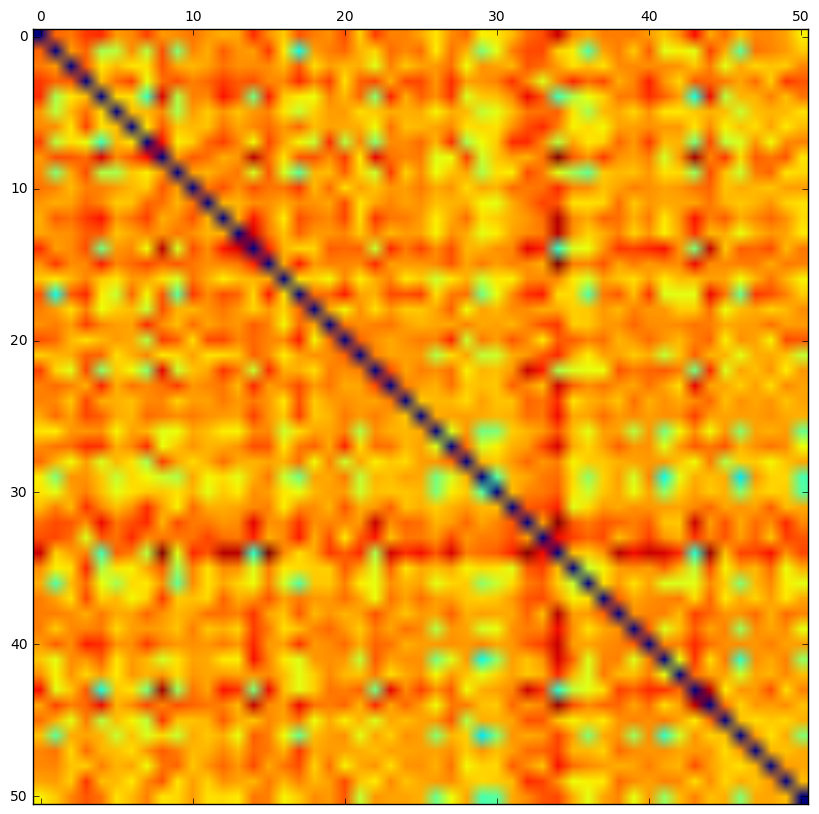

In [204]:
matshow(dd2_nohl, interpolation=None, aspect='auto')

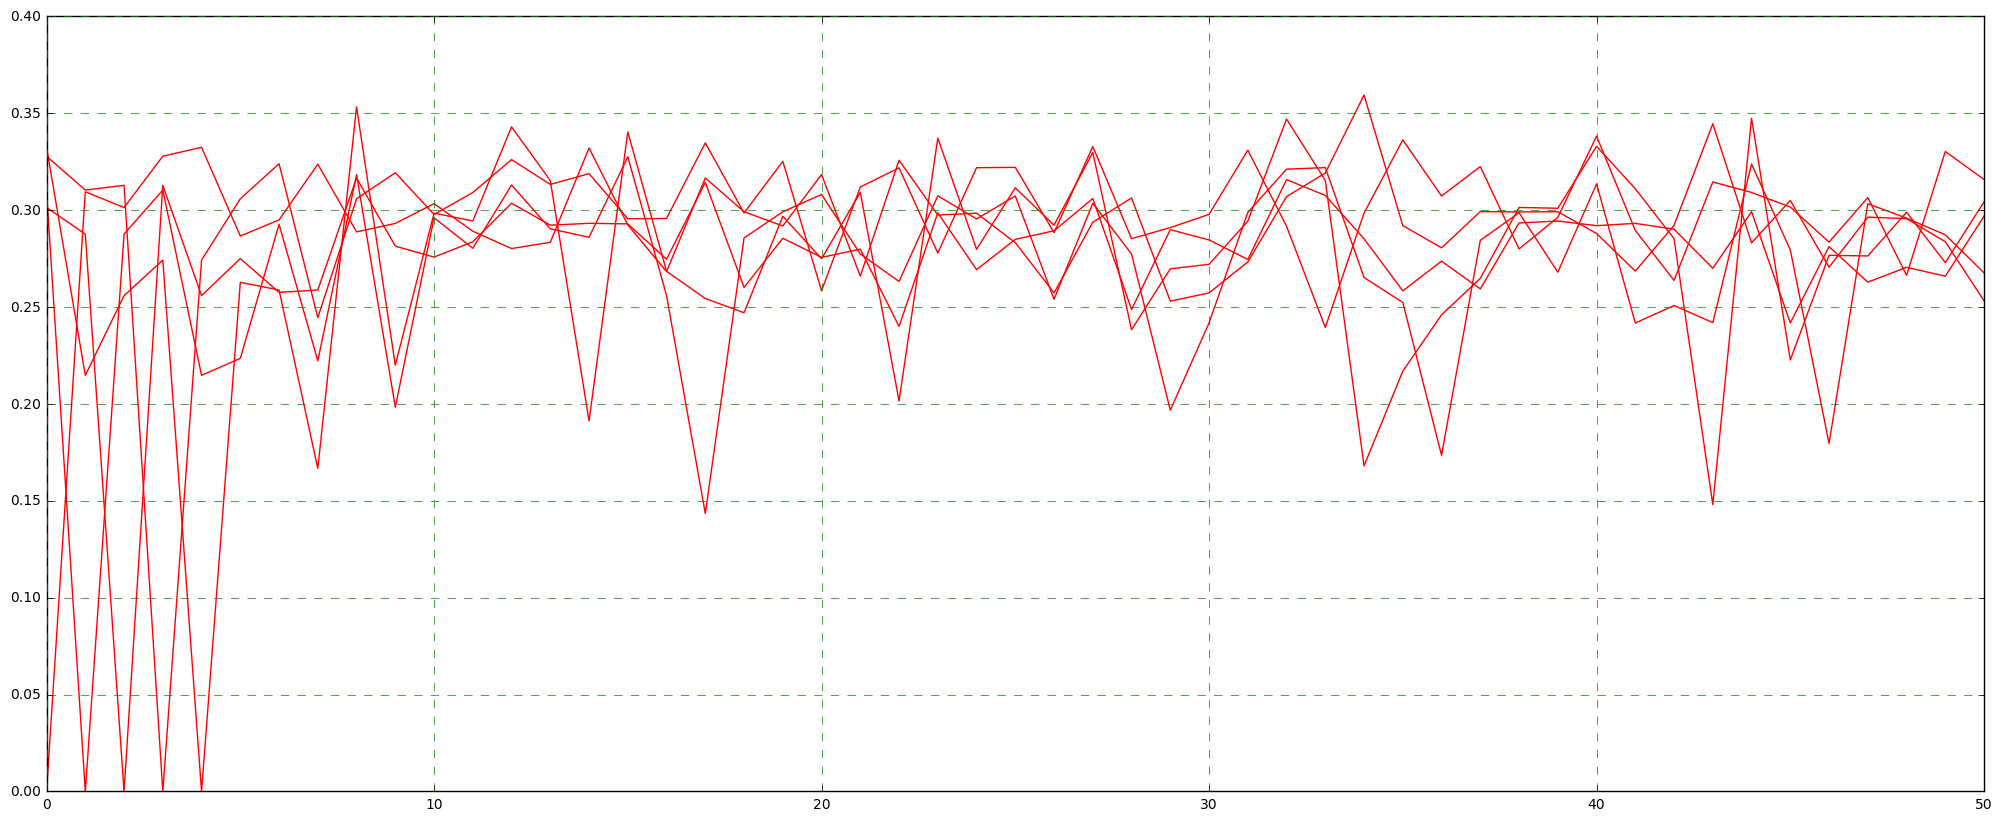

In [205]:
for sims in dd2_nohl[:5]: # for the first five states, plot the distance to between them and the other 50
    plot(sims,'r-')
grid(color='g', linestyle='--', linewidth=0.5)

In [206]:
from scipy.stats import itemfreq

db = DBSCAN(eps=0.14, min_samples=2, metric='precomputed').fit(dd2)

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)

print('Estimated number of clusters: %d' % n_clusters_)
print itemfreq(db.labels_)
print db.labels_
from operator import itemgetter
sorted(zip(state_list,db.labels_),key=itemgetter(1))

Estimated number of clusters: 3
[[-1 43]
 [ 0  2]
 [ 1  4]
 [ 2  2]]
[-1  0 -1 -1  1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1  2 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1  2 -1 -1 -1
 -1]


[('Alaska', -1),
 ('Arkansas', -1),
 ('Arizona', -1),
 ('Colorado', -1),
 ('Connecticut', -1),
 ('Delaware', -1),
 ('Florida', -1),
 ('Georgia', -1),
 ('Hawaii', -1),
 ('Iowa', -1),
 ('Idaho', -1),
 ('Illinois', -1),
 ('Indiana', -1),
 ('Kansas', -1),
 ('Louisiana', -1),
 ('Massachusetts', -1),
 ('Maryland', -1),
 ('Maine', -1),
 ('Michigan', -1),
 ('Minnesota', -1),
 ('Missouri', -1),
 ('Mississippi', -1),
 ('Montana', -1),
 ('Nebraska', -1),
 ('North Carolina', -1),
 ('New Hampshire', -1),
 ('New Jersey', -1),
 ('New Mexico', -1),
 ('Nevada', -1),
 ('Ohio', -1),
 ('Oklahoma', -1),
 ('Oregon', -1),
 ('Pennsylvania', -1),
 ('Rhodes Island', -1),
 ('South Carolina', -1),
 ('South Dakota', -1),
 ('Tennessee', -1),
 ('Utah', -1),
 ('Virginia', -1),
 ('Washington', -1),
 ('Wisconsin', -1),
 ('West Virginia', -1),
 ('Wyoming', -1),
 ('Alabama', 0),
 ('Kentucky', 0),
 ('California', 1),
 ('District of Columbia', 1),
 ('New York', 1),
 ('Texas', 1),
 ('North Dakota', 2),
 ('Vermont', 2)]

In [1]:
# eps_list = linspace(0.01,2.0,num=200)
# #eps_list = linspace(0.78,0.8,num=200)
# noise_list = array([])
# n_clusters_list = array([])
# for myeps in eps_list:
#     db = DBSCAN(myeps, min_samples=2, metric='precomputed').fit(dd2)
#     noise_list = append(noise_list, sum([ 1 if i==-1 else 0 for i in db.labels_]))
    
#     n_clusters_list = append(n_clusters_list, len(set(db.labels_)) - (1 if -1 in db.labels_ else 0))
# plot(eps_list, noise_list/51)
# plot(eps_list, n_clusters_list)
# plot([0.14,0.14],[0,5],'r-')
# grid(color='k', linestyle='--', linewidth=0.5)


Stress value:  9.45293460725


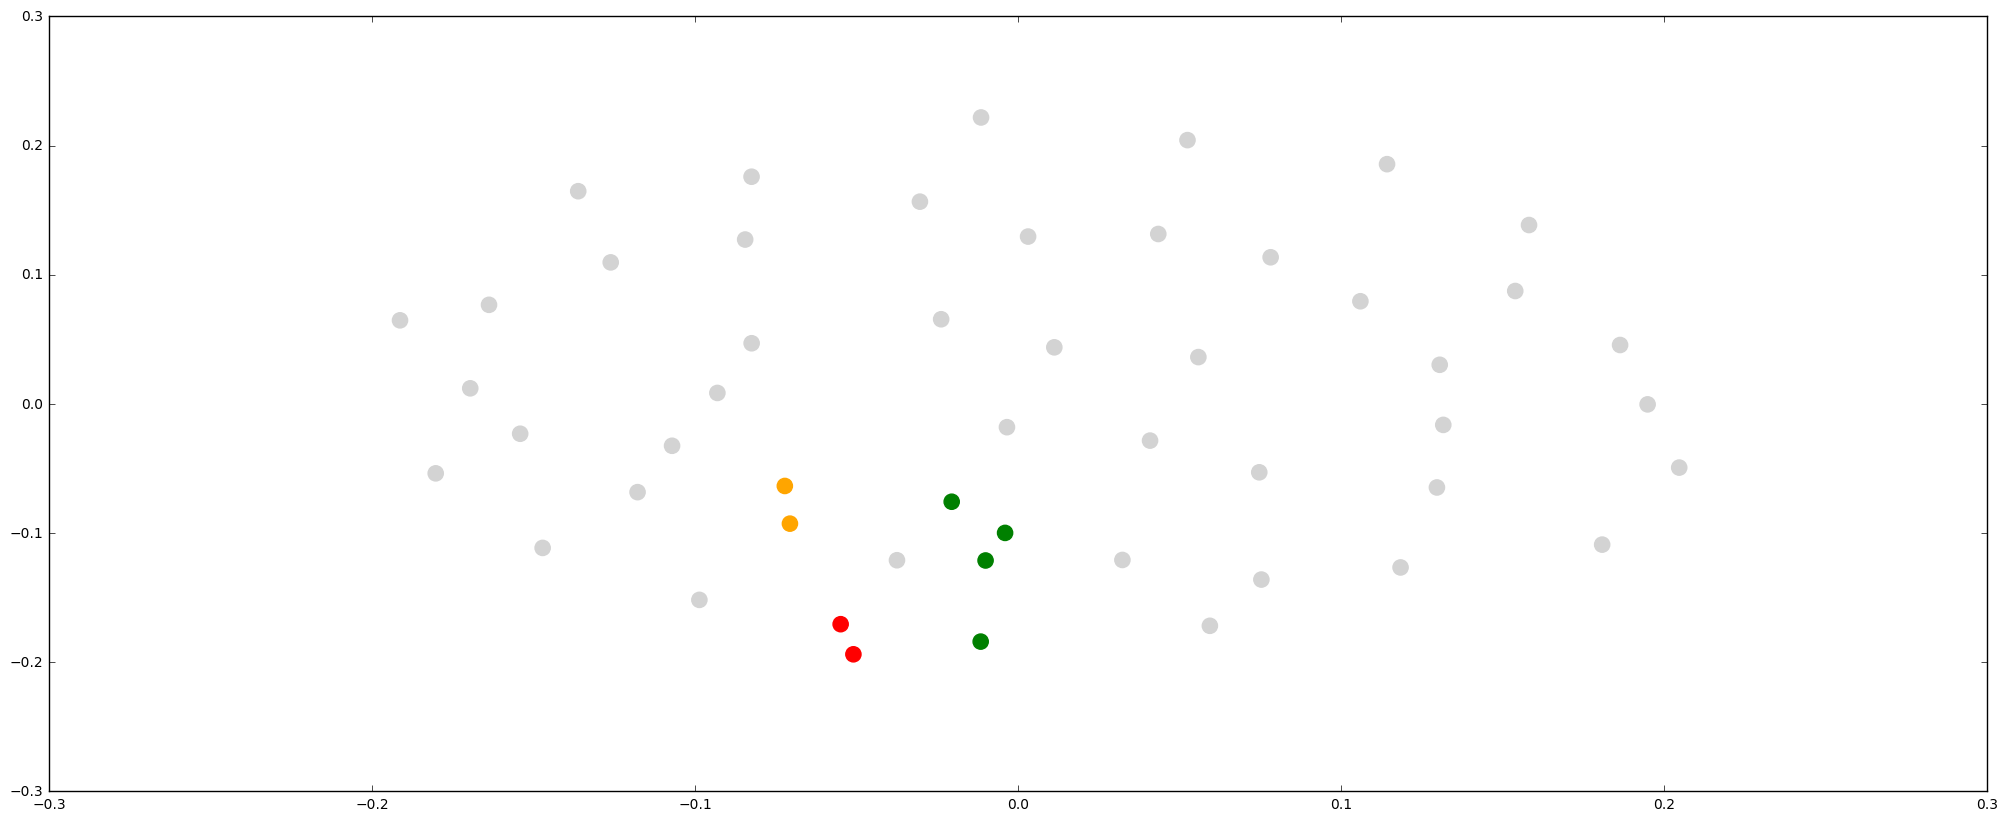

In [208]:
from sklearn import manifold
mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, dissimilarity="precomputed", n_jobs=-1)
pos = mds.fit(dd2)
print "Stress value: ", pos.stress_

# Assign colors based on clusters
db = DBSCAN(eps=0.14, min_samples=2, metric='precomputed').fit(dd2)
cols = ['lightgray', 'red', 'green', 'orange']
cc = [ cols[l+1] for l in db.labels_]
scatter(pos.embedding_.T[0], pos.embedding_.T[1], color=cc, s=120)

In [209]:
db = DBSCAN(eps=0.16, min_samples=2, metric='precomputed').fit(dd2_nohl)

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)

print('Estimated number of clusters: %d' % n_clusters_)
print itemfreq(db.labels_)
print db.labels_
from operator import itemgetter
sorted(zip(state_list,db.labels_),key=itemgetter(1))

Estimated number of clusters: 3
[[-1 42]
 [ 0  2]
 [ 1  4]
 [ 2  3]]
[-1  0 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1  0 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1  2 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1  2 -1  1 -1 -1  2 -1 -1 -1
 -1]


[('Alaska', -1),
 ('Arkansas', -1),
 ('Arizona', -1),
 ('Colorado', -1),
 ('Connecticut', -1),
 ('District of Columbia', -1),
 ('Delaware', -1),
 ('Florida', -1),
 ('Georgia', -1),
 ('Hawaii', -1),
 ('Iowa', -1),
 ('Idaho', -1),
 ('Indiana', -1),
 ('Kansas', -1),
 ('Louisiana', -1),
 ('Massachusetts', -1),
 ('Maryland', -1),
 ('Maine', -1),
 ('Michigan', -1),
 ('Minnesota', -1),
 ('Missouri', -1),
 ('Mississippi', -1),
 ('Montana', -1),
 ('Nebraska', -1),
 ('North Carolina', -1),
 ('New Hampshire', -1),
 ('New Jersey', -1),
 ('New Mexico', -1),
 ('Nevada', -1),
 ('Ohio', -1),
 ('Oklahoma', -1),
 ('Oregon', -1),
 ('Pennsylvania', -1),
 ('Rhodes Island', -1),
 ('South Carolina', -1),
 ('Tennessee', -1),
 ('Utah', -1),
 ('Virginia', -1),
 ('Washington', -1),
 ('Wisconsin', -1),
 ('West Virginia', -1),
 ('Wyoming', -1),
 ('Alabama', 0),
 ('Kentucky', 0),
 ('California', 1),
 ('Illinois', 1),
 ('New York', 1),
 ('Texas', 1),
 ('North Dakota', 2),
 ('South Dakota', 2),
 ('Vermont', 2)]

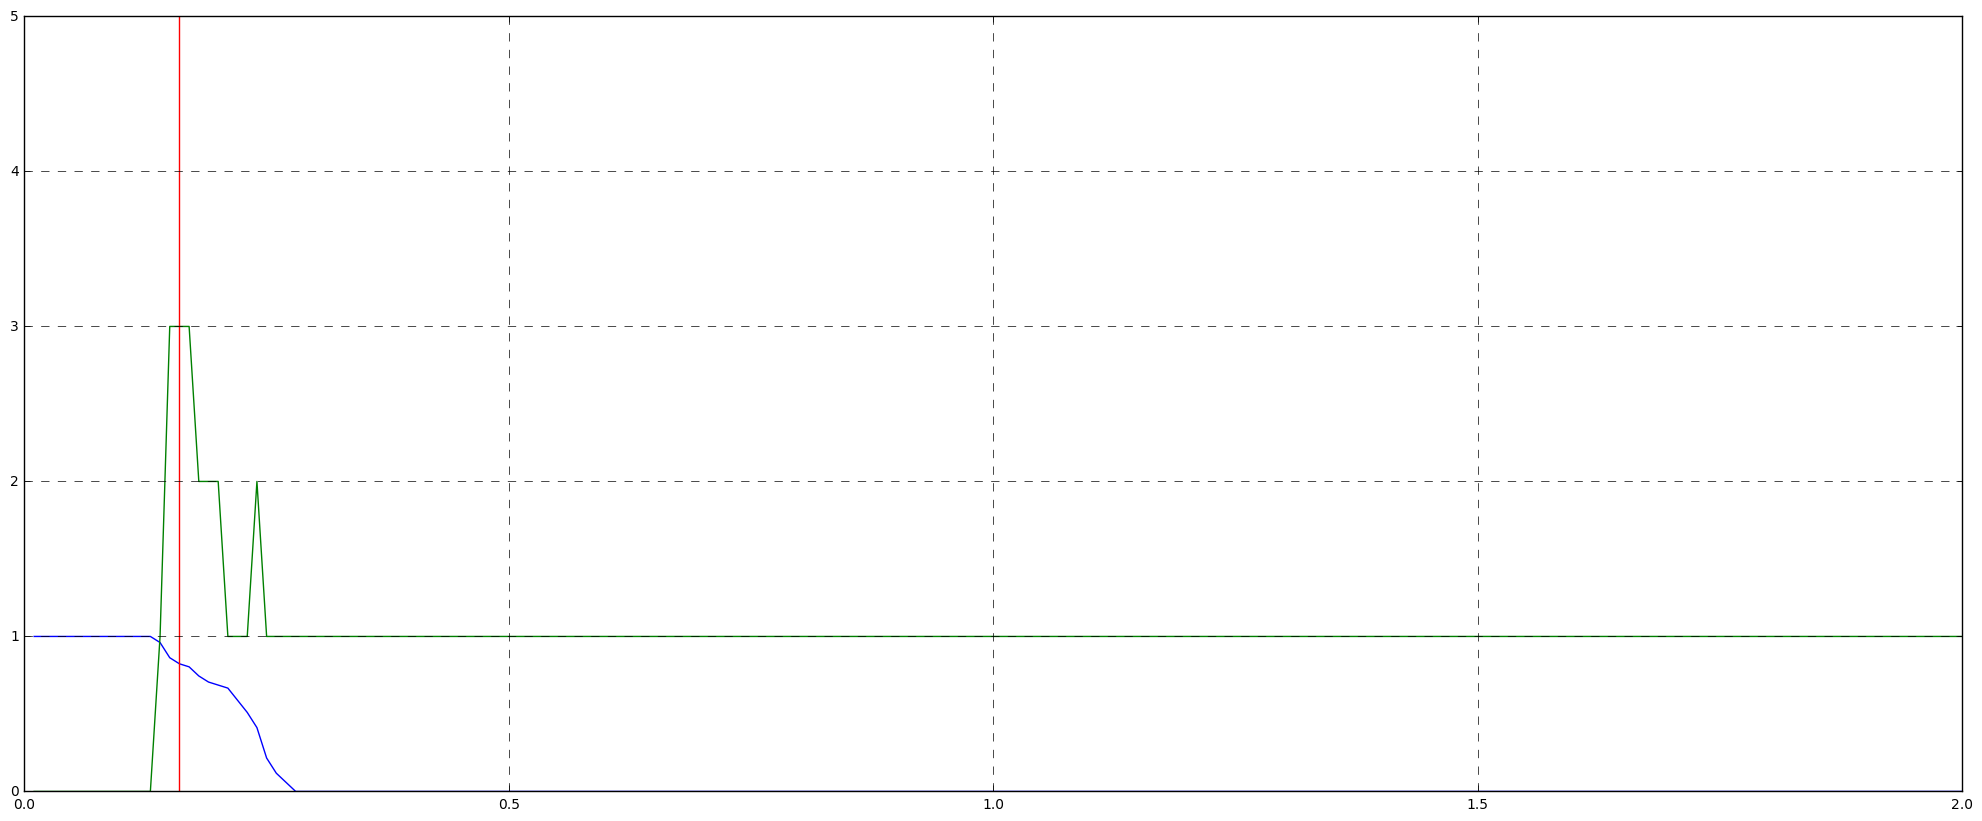

In [210]:
eps_list = linspace(0.01,2.0,num=200)
#eps_list = linspace(0.78,0.8,num=200)
noise_list = array([])
n_clusters_list = array([])
for myeps in eps_list:
    db = DBSCAN(myeps, min_samples=2, metric='precomputed').fit(dd2_nohl)
    noise_list = append(noise_list, sum([ 1 if i==-1 else 0 for i in db.labels_]))
    
    n_clusters_list = append(n_clusters_list, len(set(db.labels_)) - (1 if -1 in db.labels_ else 0))
plot(eps_list, noise_list/51)
plot(eps_list, n_clusters_list)
plot([0.16,0.16],[0,5],'r-')
grid(color='k', linestyle='--', linewidth=0.5)

Stress value:  9.35744131988


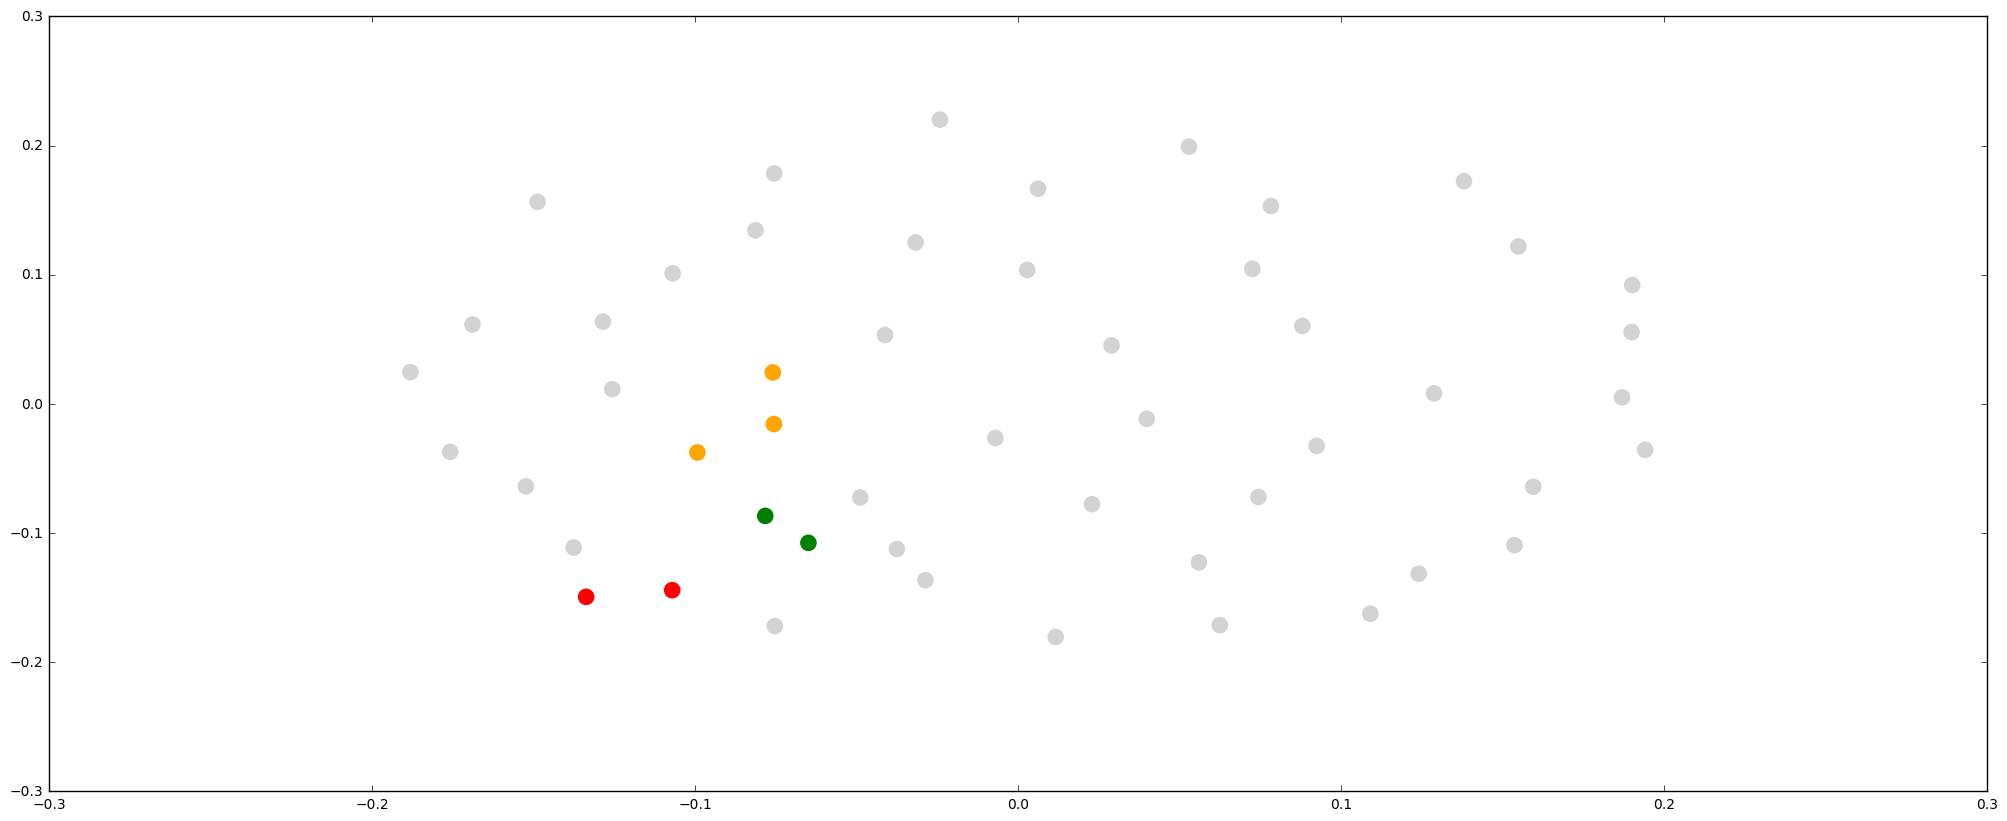

In [211]:
mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, dissimilarity="precomputed", n_jobs=-1)
pos = mds.fit(dd2)
print "Stress value: ", pos.stress_

# Assign colors based on clusters
db = DBSCAN(eps=0.15, min_samples=2, metric='precomputed').fit(dd2_nohl)
cols = ['lightgray', 'red', 'green', 'orange']
cc = [ cols[l+1] for l in db.labels_]
scatter(pos.embedding_.T[0], pos.embedding_.T[1], color=cc, s=120)

In [212]:
# for i in range(len(db.labels_)):
#     plot(normalized_year_month_df[state_list[i]],'r-' if db.labels_[i]==0 else 'y-')

In [213]:
# normalized_year_month_df_sort=sorted(zip(array(normalized_year_month_df.T),db.labels_),key=itemgetter(1))
# normalized_year_month_df_sort2=[el[0] for el in normalized_year_month_df_sort]
# matshow(normalized_year_month_df_sort2, interpolation=None, aspect='auto')

In [154]:
# before = normalized_year_month_df.T
# after = normalized_year_month_df_sort2
# separator = array([[ 0 ] * 51]).T
# matshow(hstack((before, separator, after)), interpolation=None, aspect='auto')

In [240]:
normalized_year_df.index = pd.to_datetime(normalized_year_df.index, format='%Y')
state_list = normalized_year_df.columns
ddy1 = [ [ (dtw(normalized_year_df[state_list[x]],normalized_year_df[state_list[y]],distance)[0] if y > x else -1)  for y in range(len(state_list)) ] 
       for x in range(len(state_list)) ] #the for with x is the outer for
ddy2 = [ [ (ddy1[x][y] if y > x else ddy1[y][x])  for y in range(len(state_list)) ] for x in range(len(state_list)) ]
for i in range(len(state_list)):
    ddy2[i][i] = 0.0

In [239]:
# matshow(ddy2, interpolation=None, aspect='auto')

In [247]:
db = DBSCAN(eps=0.225, min_samples=2, metric='precomputed').fit(ddy2)

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)

print('Estimated number of clusters: %d' % n_clusters_)
print itemfreq(db.labels_)
print db.labels_
from operator import itemgetter
sorted(zip(state_list,db.labels_),key=itemgetter(1))

Estimated number of clusters: 3
[[-1 15]
 [ 0 32]
 [ 1  2]
 [ 2  2]]
[-1 -1  0  0  0 -1  0  0  1 -1  0  0 -1 -1  0  2 -1  0  0  0  0 -1  0  0  0
  0 -1  1  0 -1  0  0 -1  0  0  0  0  0  2  0 -1 -1 -1  0  0  0 -1  0  0  0
  0]


[('Alaska', -1),
 ('Alabama', -1),
 ('Colorado', -1),
 ('Florida', -1),
 ('Iowa', -1),
 ('Idaho', -1),
 ('Kansas', -1),
 ('Maine', -1),
 ('Montana', -1),
 ('North Dakota', -1),
 ('New Mexico', -1),
 ('South Carolina', -1),
 ('South Dakota', -1),
 ('Tennessee', -1),
 ('Vermont', -1),
 ('Arkansas', 0),
 ('Arizona', 0),
 ('California', 0),
 ('Connecticut', 0),
 ('District of Columbia', 0),
 ('Georgia', 0),
 ('Hawaii', 0),
 ('Illinois', 0),
 ('Kentucky', 0),
 ('Louisiana', 0),
 ('Massachusetts', 0),
 ('Maryland', 0),
 ('Michigan', 0),
 ('Minnesota', 0),
 ('Missouri', 0),
 ('Mississippi', 0),
 ('North Carolina', 0),
 ('New Hampshire', 0),
 ('New Jersey', 0),
 ('Nevada', 0),
 ('New York', 0),
 ('Ohio', 0),
 ('Oklahoma', 0),
 ('Oregon', 0),
 ('Rhodes Island', 0),
 ('Texas', 0),
 ('Utah', 0),
 ('Virginia', 0),
 ('Washington', 0),
 ('Wisconsin', 0),
 ('West Virginia', 0),
 ('Wyoming', 0),
 ('Delaware', 1),
 ('Nebraska', 1),
 ('Indiana', 2),
 ('Pennsylvania', 2)]

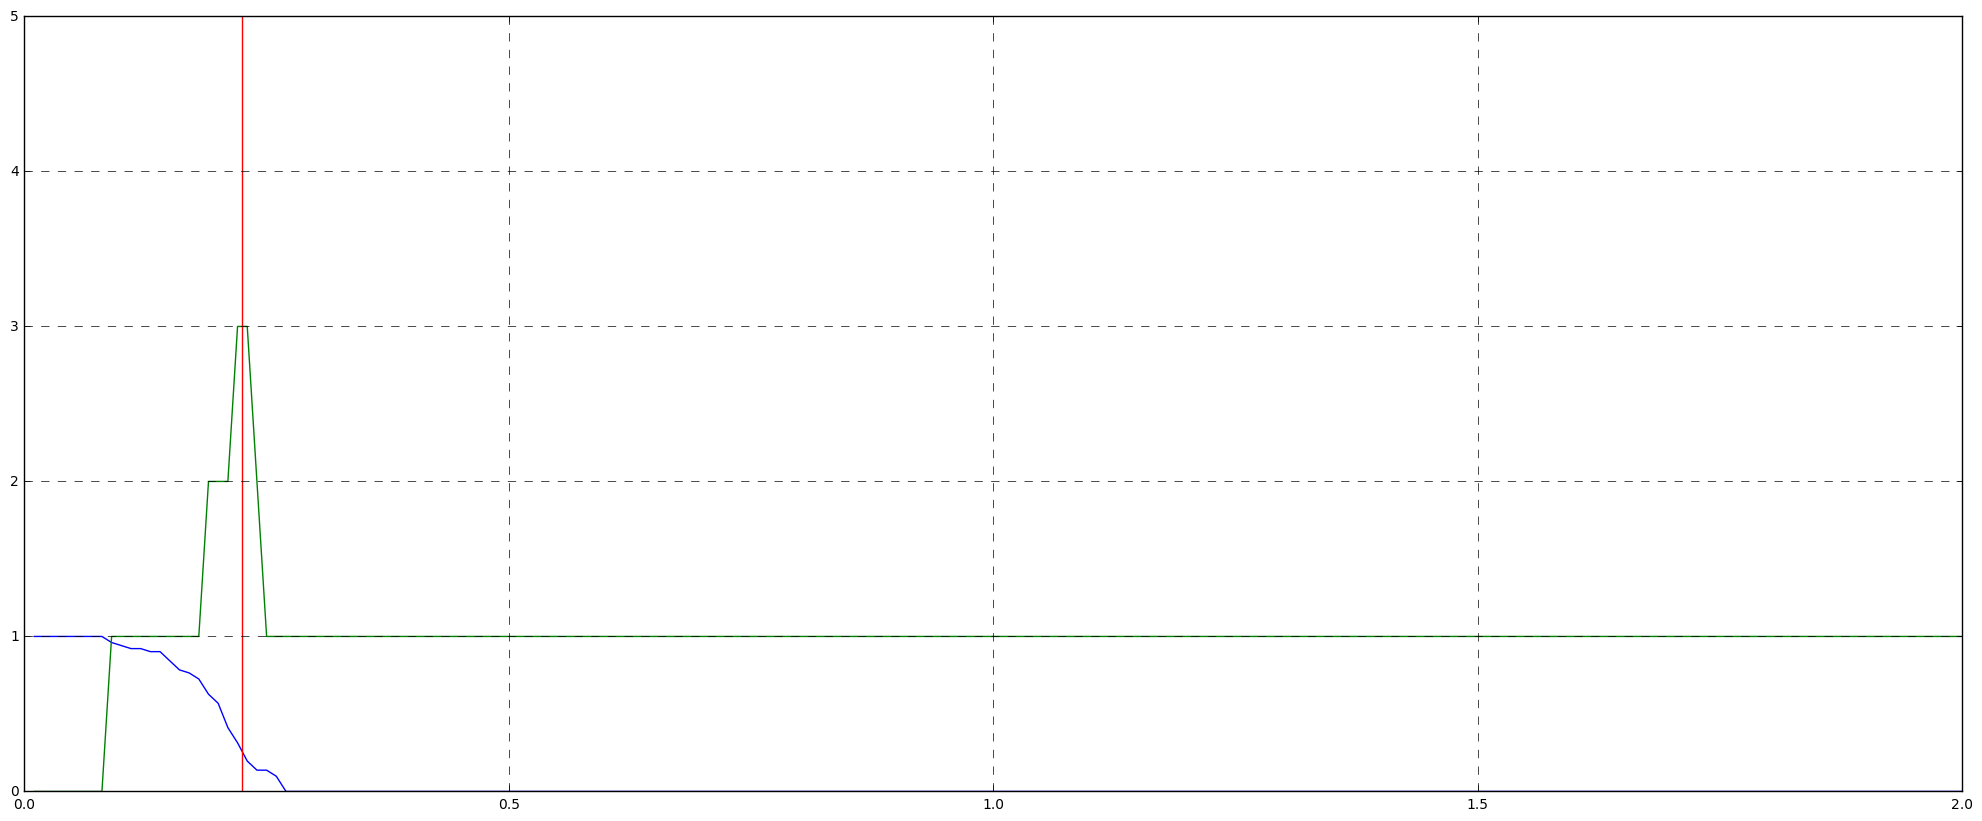

In [246]:
eps_list = linspace(0.01,2.0,num=200)
#eps_list = linspace(0.78,0.8,num=200)
noise_list = array([])
n_clusters_list = array([])
for myeps in eps_list:
    db = DBSCAN(myeps, min_samples=2, metric='precomputed').fit(ddy2)
    noise_list = append(noise_list, sum([ 1 if i==-1 else 0 for i in db.labels_]))
    
    n_clusters_list = append(n_clusters_list, len(set(db.labels_)) - (1 if -1 in db.labels_ else 0))
plot(eps_list, noise_list/51)
plot(eps_list, n_clusters_list)
plot([0.225,0.225],[0,5],'r-')
grid(color='k', linestyle='--', linewidth=0.5)

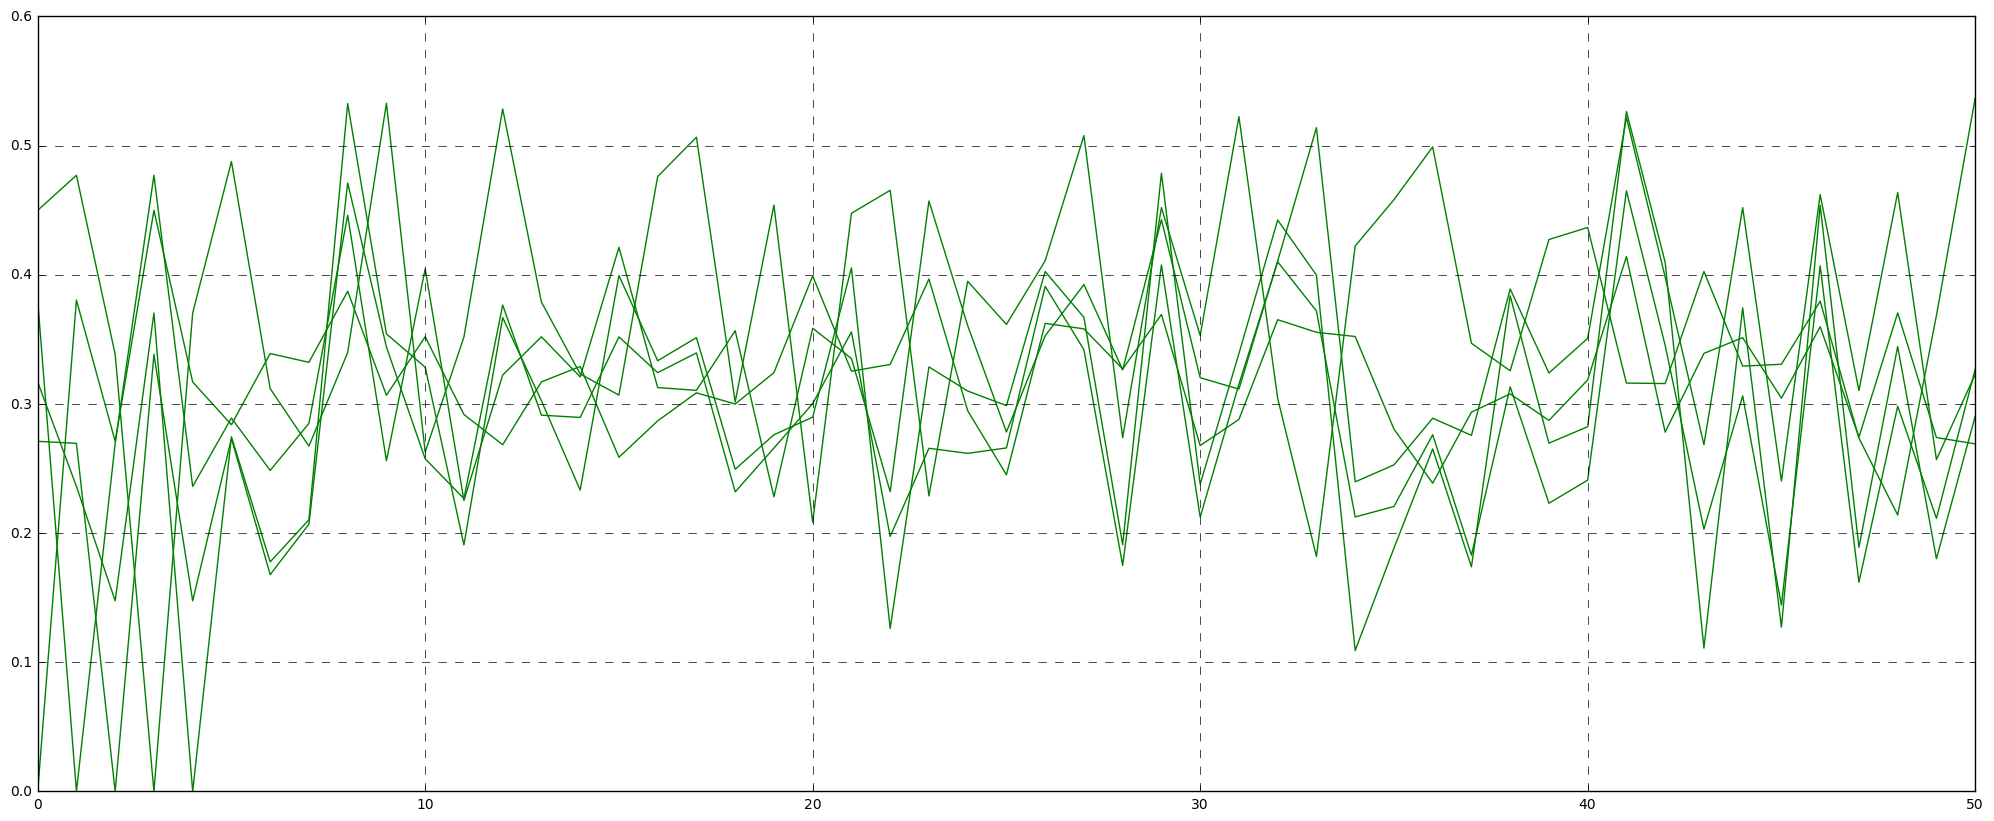

In [258]:
for sims in ddy2[:5]: # for the first five states, plot the distance to between them and the other 50
    plot(sims,'g-')
grid(color='k', linestyle='--', linewidth=0.5)

In [248]:
normalized_month_df.index = pd.to_datetime(normalized_month_df.index, format='%m')
state_list = normalized_year_df.columns
ddm1 = [ [ (dtw(normalized_month_df[state_list[x]],normalized_month_df[state_list[y]],distance)[0] if y > x else -1)  for y in range(len(state_list)) ] 
       for x in range(len(state_list)) ] #the for with x is the outer for
ddm2 = [ [ (ddm1[x][y] if y > x else ddm1[y][x])  for y in range(len(state_list)) ] for x in range(len(state_list)) ]
for i in range(len(state_list)):
    ddm2[i][i] = 0.0

In [254]:
db = DBSCAN(eps=0.15, min_samples=2, metric='precomputed').fit(ddm2)

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)

print('Estimated number of clusters: %d' % n_clusters_)
print itemfreq(db.labels_)
print db.labels_
from operator import itemgetter
sorted(zip(state_list,db.labels_),key=itemgetter(1))

Estimated number of clusters: 6
[[-1 28]
 [ 0  3]
 [ 1  5]
 [ 2  8]
 [ 3  2]
 [ 4  3]
 [ 5  2]]
[-1  0  1 -1  2  0  2 -1 -1 -1  2 -1 -1 -1  2  1  3  0  4 -1  1 -1  2  4  4
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  2 -1 -1 -1  3  1 -1  2  2  5  1 -1 -1  5 -1
 -1]


[('Alaska', -1),
 ('Arizona', -1),
 ('District of Columbia', -1),
 ('Delaware', -1),
 ('Florida', -1),
 ('Hawaii', -1),
 ('Iowa', -1),
 ('Idaho', -1),
 ('Massachusetts', -1),
 ('Maine', -1),
 ('Mississippi', -1),
 ('Montana', -1),
 ('Nebraska', -1),
 ('North Carolina', -1),
 ('North Dakota', -1),
 ('New Hampshire', -1),
 ('New Jersey', -1),
 ('New Mexico', -1),
 ('Nevada', -1),
 ('New York', -1),
 ('Oklahoma', -1),
 ('Oregon', -1),
 ('Pennsylvania', -1),
 ('South Dakota', -1),
 ('Vermont', -1),
 ('Washington', -1),
 ('West Virginia', -1),
 ('Wyoming', -1),
 ('Alabama', 0),
 ('Colorado', 0),
 ('Kentucky', 0),
 ('Arkansas', 1),
 ('Indiana', 1),
 ('Maryland', 1),
 ('South Carolina', 1),
 ('Virginia', 1),
 ('California', 2),
 ('Connecticut', 2),
 ('Georgia', 2),
 ('Illinois', 2),
 ('Michigan', 2),
 ('Ohio', 2),
 ('Tennessee', 2),
 ('Texas', 2),
 ('Kansas', 3),
 ('Rhodes Island', 3),
 ('Louisiana', 4),
 ('Minnesota', 4),
 ('Missouri', 4),
 ('Utah', 5),
 ('Wisconsin', 5)]

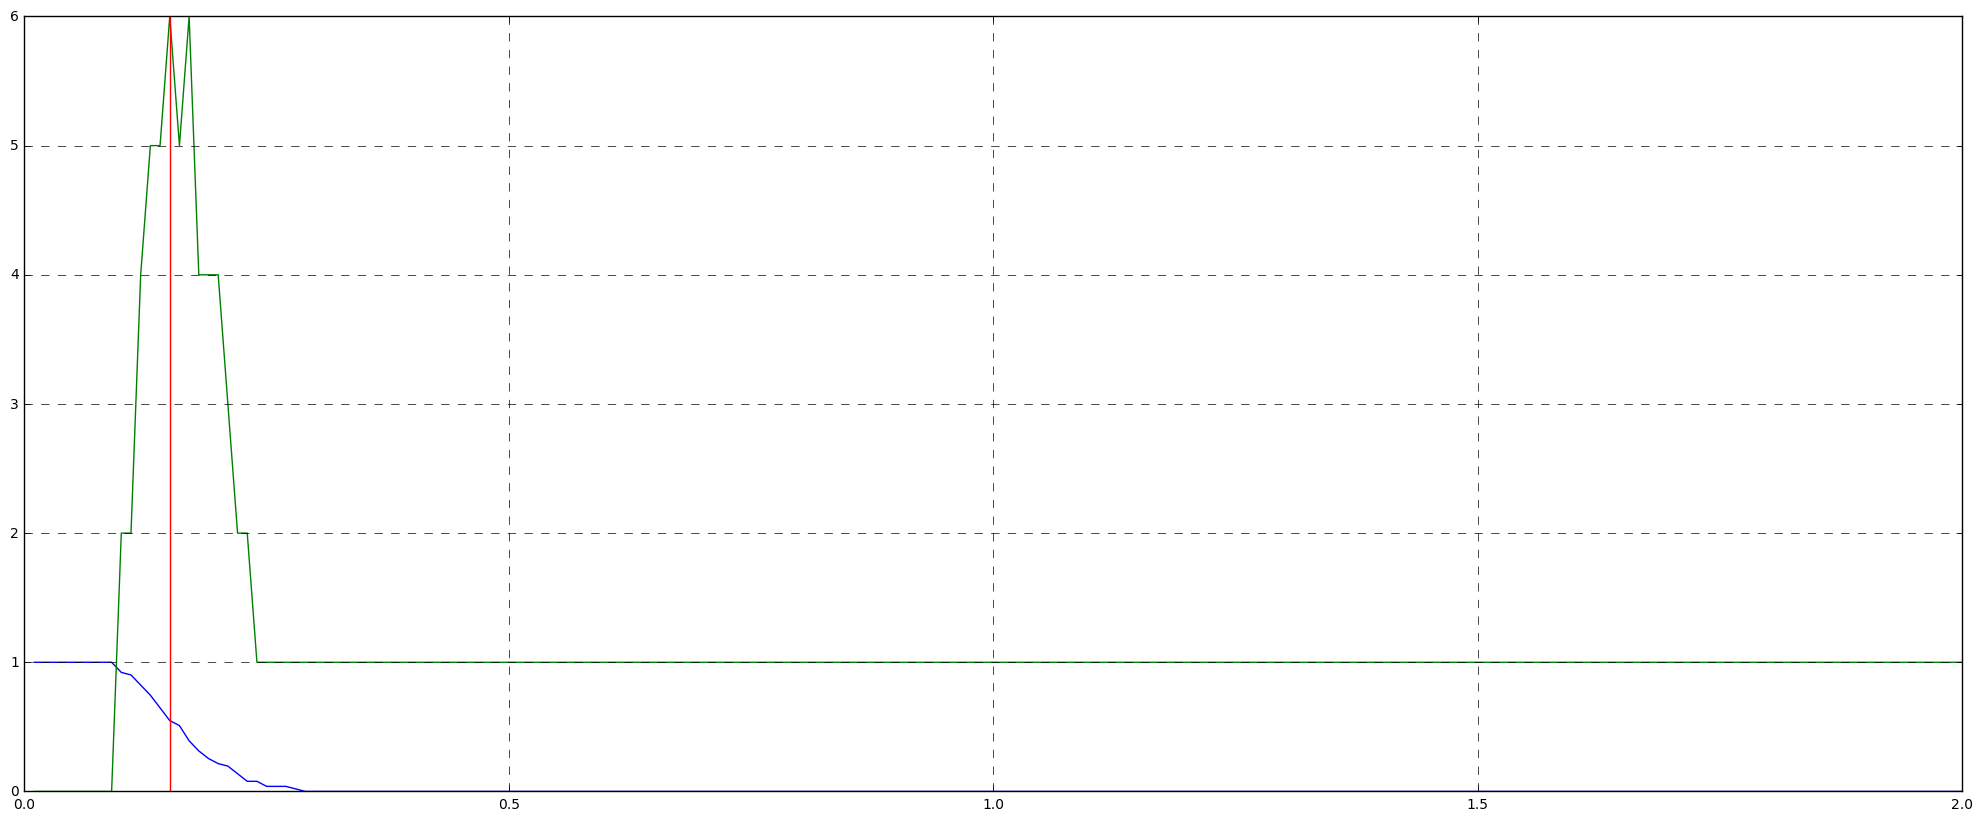

In [253]:
eps_list = linspace(0.01,2.0,num=200)
#eps_list = linspace(0.78,0.8,num=200)
noise_list = array([])
n_clusters_list = array([])
for myeps in eps_list:
    db = DBSCAN(myeps, min_samples=2, metric='precomputed').fit(ddm2)
    noise_list = append(noise_list, sum([ 1 if i==-1 else 0 for i in db.labels_]))
    
    n_clusters_list = append(n_clusters_list, len(set(db.labels_)) - (1 if -1 in db.labels_ else 0))
plot(eps_list, noise_list/51)
plot(eps_list, n_clusters_list)
plot([0.15,0.15],[0,6],'r-')
grid(color='k', linestyle='--', linewidth=0.5)